In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1e-04)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

# Define the function
def f(x1, x2):
    return 3 * np.cos(2 * np.pi * (x1**2 - x2**2))

# Set the parameters
lower_bound = -1
upper_bound = 1
n_samples = 1000

# Generate the data
x1_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)
x2_values = np.linspace(lower_bound, upper_bound, n_samples).reshape(n_samples, 1)

# Get a meshgrid for x1 and x2 values
X1, X2 = np.meshgrid(x1_values, x2_values)

# Calculate y values using the function
y_values = f(X1, X2)

# Reshape the data for training
X = np.column_stack((X1.ravel(), X2.ravel()))
y = y_values.ravel()


from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X[:-5], y[:-5]  # Displaying the first 5 samples


2023-10-17 14:04:55.804493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:04:56.279474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Our method / CP decomposition
* n = 4
* 64 Neurons per Dense layer 
* Lr: 0.001
* Batch Size: 64
* Epochs: 150, Stopping when prediction better than 1e-07

In [5]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (2,)
filters = 64
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 50

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")


Epoch 1/50
12500/12500 [==============================] - 48s 4ms/step - loss: 4.6558 - val_loss: 4.6528
Epoch 2/50
12500/12500 [==============================] - 46s 4ms/step - loss: 4.6539 - val_loss: 4.6545
Epoch 3/50
12500/12500 [==============================] - 46s 4ms/step - loss: 4.2808 - val_loss: 3.2552
Epoch 4/50
12500/12500 [==============================] - 46s 4ms/step - loss: 3.1644 - val_loss: 3.0605
Epoch 5/50
10618/12500 [========================>.....] - ETA: 6s - loss: 3.0795

KeyboardInterrupt: 

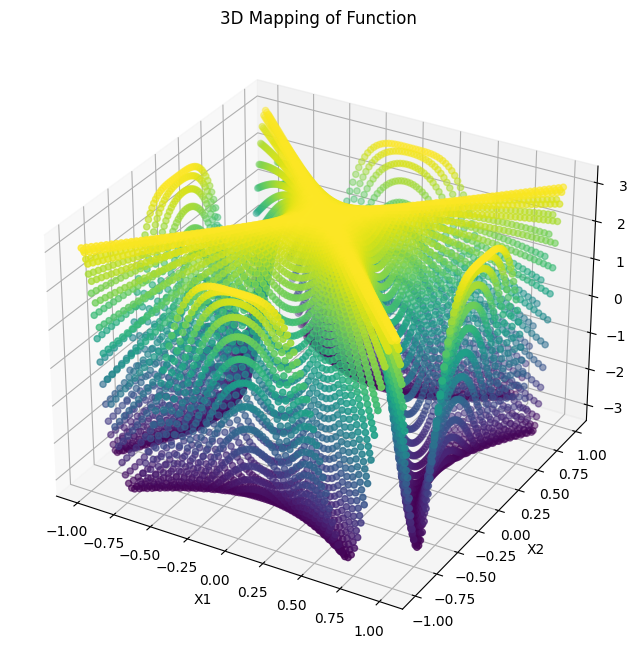

In [ ]:

import matplotlib.pyplot as plt

num_test_samples = 100
x1_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
x2_test_values = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

# Get a meshgrid for x1 and x2 test values
X1_test, X2_test = np.meshgrid(x1_test_values, x2_test_values)

# Calculate y true values using the function
y_true_3d = f(X1_test, X2_test)

X_test_3d = np.column_stack((X1_test.ravel(), X2_test.ravel()))
y_true_3d = y_true_3d.ravel()


# 3D visualization of the data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(X_test_3d[:, 0], X_test_3d[:, 1], y_true_3d, c=y_true_3d, cmap='viridis', marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y_true_3d')
ax.set_title('3D Mapping of Function')
ax.grid(True)

plt.show()
